### **Imports necesarios**

In [7]:
import sys
from pathlib import Path

# Pedir la ruta al usuario
user_path = input("Ingrese la ruta raíz del proyecto (ej: C:/Users/User/Projects/project): ").strip()

PROJECT_ROOT = Path(user_path)

# Verificar que la ruta exista
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"La ruta ingresada no existe: {PROJECT_ROOT}")

# Añadir al sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT añadido al path:", PROJECT_ROOT)


PROJECT_ROOT añadido al path: C:\Users\Lottie\Desktop\project


### **Carga del dataset original**

In [8]:
# Importar pandas
import pandas as pd

# Cargar original_train.csv y renombrar columnas
df = pd.read_csv("../data/original_train.csv")
df.columns = ["ImageId", "EncodedPixels", "ClassId"]
print(df.head())


         ImageId  EncodedPixels  \
0  0002cc93b.jpg              1   
1  0007a71bf.jpg              3   
2  000a4bcdd.jpg              1   
3  000f6bf48.jpg              4   
4  0014fce06.jpg              3   

                                             ClassId  
0  29102 12 29346 24 29602 24 29858 24 30114 24 3...  
1  18661 28 18863 82 19091 110 19347 110 19603 11...  
2  37607 3 37858 8 38108 14 38359 20 38610 25 388...  
3  131973 1 132228 4 132483 6 132738 8 132993 11 ...  
4  229501 11 229741 33 229981 55 230221 77 230468...  


### **Identificación de imágenes con y sin defectos**

In [ ]:
# Crear DataFrame con ImageId únicos y columna has_defect
image_ids = df["ImageId"].unique()
df_defect = df.groupby("ImageId")["EncodedPixels"].apply(lambda x: x.notna().any()).reset_index()
df_defect.columns = ["ImageId", "has_defect"]


### **División en train / validation / test**

In [ ]:
# Dividir en train, val y test con estratificación
from sklearn.model_selection import train_test_split

train_ids, temp_ids = train_test_split(
    df_defect, test_size=0.30, stratify=df_defect["has_defect"], random_state=42
)

val_ids, test_ids = train_test_split(
    temp_ids, test_size=0.50, stratify=temp_ids["has_defect"], random_state=42
)

### **Construcción de los CSV finales**

In [5]:
# Crear DataFrames finales para train, val y test
train_df = df[df["ImageId"].isin(train_ids["ImageId"])]
val_df   = df[df["ImageId"].isin(val_ids["ImageId"])]
test_df  = df[df["ImageId"].isin(test_ids["ImageId"])]

# Guardar los DataFrames en archivos CSV
train_df.to_csv("../data/train_split.csv", index=False)
val_df.to_csv("../data/val_split.csv", index=False)
test_df.to_csv("../data/test_split.csv", index=False)


### **Visualización de imágenes y máscaras**

In [30]:
from src.data.utils_rle import rle_decode
import matplotlib.pyplot as plt
import numpy as np
import cv2


def show_image_with_masks(image_id, df, img_dir="../data/train_images"):
    image_path = f"{img_dir}/{image_id}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"No se pudo cargar la imagen: {image_path}")
        return

    img = cv2.resize(img, (256, 256))

    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Imagen")
    axes[0].axis("off")

    classes = [1, 2, 3, 4]

    for i, cls in enumerate(classes):
        row = df[(df.ImageId == image_id) & (df.ClassId == cls)]

        if row.empty or row["EncodedPixels"].isnull().values[0]:
            mask = np.zeros((256, 256))
        else:
            mask = rle_decode(row["EncodedPixels"].values[0], (256, 1600))
            mask = cv2.resize(mask, (256, 256))

        axes[i + 1].imshow(mask, cmap="gray")
        axes[i + 1].set_title(f"Clase {cls}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()



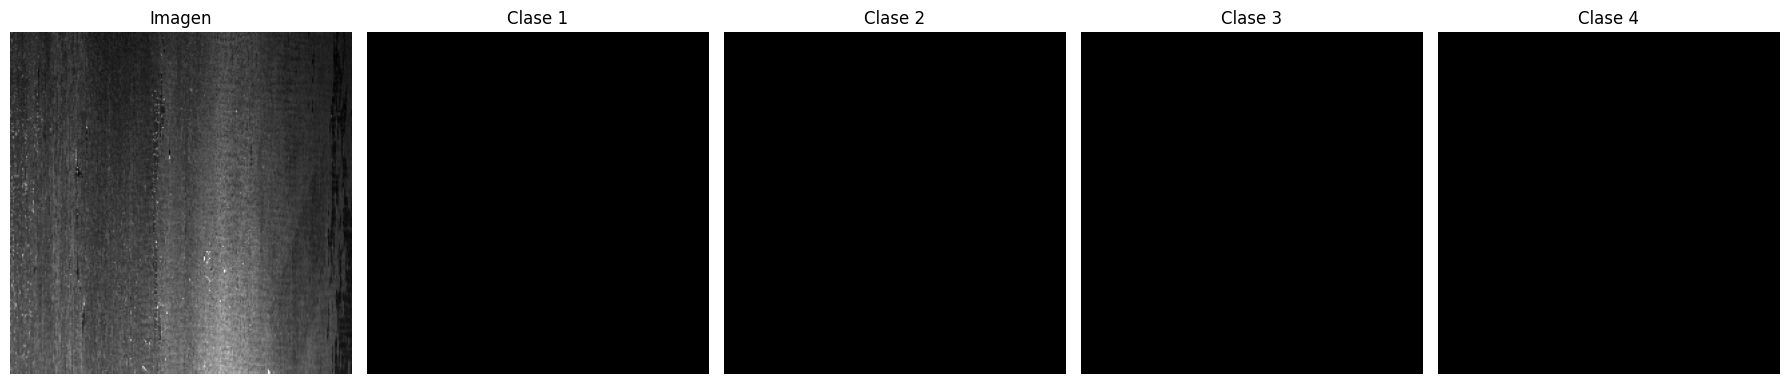

In [32]:
image_id = df["ImageId"].iloc[0]
show_image_with_masks(image_id, df)


El propósito de este bloque es realizar una verificación visual del dataset,
mostrando una imagen de acero junto con sus respectivas máscaras de defectos por
clase. Esta visualización permite comprobar que las anotaciones en formato
Run-Length Encoding (RLE) han sido correctamente decodificadas a máscaras
binarias píxel a píxel.

### **Garantizar consistencia en columnas**

In [33]:
import pandas as pd

df = pd.read_csv("../data/train_split.csv")
df.columns = ["ImageId", "EncodedPixels", "ClassId"]
df.to_csv("../data/train_split.csv", index=False)

---

### **Verificación de la división del dataset (train / val / test)**


In [11]:
import pandas as pd

df = pd.read_csv("../data/original_train.csv")
print("Total imágenes únicas:", df["ImageId"].nunique())

train_df = pd.read_csv("../data/train_split.csv")
print("Train imágenes únicas:", train_df["ImageId"].nunique())

val_df = pd.read_csv("../data/val_split.csv")
print("Val imágenes únicas:", val_df["ImageId"].nunique())

test_df = pd.read_csv("../data/test_split.csv")
print("Test imágenes únicas:", test_df["ImageId"].nunique())

total = (
    train_df["ImageId"].nunique()
    + val_df["ImageId"].nunique()
    + test_df["ImageId"].nunique()
)

print("Suma total:", total)


Total imágenes únicas: 6666
Train imágenes únicas: 4666
Val imágenes únicas: 1000
Test imágenes únicas: 1000
Suma total: 6666
